# Step 1 -- Extraction of Quantitiative Values from Traces

# Introduction

**Hello. All of the cells in this Jupyter Notebook are meant to run together.
To run the program, click 'Restart Kernel and Run All Cells' under the 'Run' tab above. 
Designed to have input data files of a specific protocol - two files of the fluorescence intensity from 9 min 30s recordings of particular neurons and one file of the cell ROI coordinates**

# Importing matplotlib, numpy, and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, peak_prominences, find_peaks_cwt
from scipy import signal
from numpy.fft import fft, ifft
from operator import itemgetter
from pybaselines import Baseline, utils
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import time
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import*
from matplotlib.figure import Figure
import csv
from numpy import diff
from bisect import bisect_left
import math

### CSV file that GUI will add cell data to

In [2]:
#CSVfileName = "5HT Blocker Mechanical Poke Cell Data.csv"
#CSVfileName = "Avil Mechanical Poke Cell Data.csv"
#CSVfileName = "Hexamethonium Mechanical Poke Cell Data.csv"
#CSVfileName = "Test Output File.csv"
CSVfileName = "NMU Mechanical Poke Cell Data.csv"

# Getting Data Files from user 

In [3]:
fileList = []
regionFileList = []

# Open file explorer via tkinter for user to select the 3 data files to read in
import tkinter.messagebox 
from tkinter.filedialog import askopenfilename

tkinter.Tk().withdraw()
tkinter.messagebox.showinfo("Loading in a recording's 3 Data Files",  "Please select the files of the recording you'd like to analyze IN THE ORDER: \
Outer Grid, Inner Grid, Region Data. THE ORDER MATTERS.") 

filename1 = askopenfilename()
fileData = open(filename1, "r")
fileList.append(fileData)
print(filename1)

filename2 = askopenfilename()
fileData = open(filename2, "r")
fileList.append(fileData)
print(filename2)

filename3 = askopenfilename()
fileData = open(filename3, "r")
regionFileList.append(fileData)
print(filename3)

print("Done")

//mfad/researchmn/PHYSIO/SZURSZEWSKI/SHARED/Charlie/Data Logs for Jupyter/NMU/Ileum MYP/5-23-24/Ileum 3/Ileum 3 Upper 6/5-23-24 Ileum 3 Outer Upper 6.LOG
//mfad/researchmn/PHYSIO/SZURSZEWSKI/SHARED/Charlie/Data Logs for Jupyter/NMU/Ileum MYP/5-23-24/Ileum 3/Ileum 3 Upper 6/5-23-24 Ileum 3 Inner Upper 6.LOG
//mfad/researchmn/PHYSIO/SZURSZEWSKI/SHARED/Charlie/Data Logs for Jupyter/NMU/Ileum MYP/5-23-24/Ileum 3/Ileum 3 Upper 6/5-23-24 Ileum 3 Regdata Upper 6.LOG
Done


# Set times when the stimula started and ended -- for vertical green lines on plots

In [4]:
# Since the frame rate is slightly faster than 50 fps and stages were triggered by frame #, times are not integer values

vLineList = [29.85, 39.9, 50, 55.11, 74.98, 85.04, 95, 100.24, 120.11, 130.17, 140, 145.37, 165.24, 175.3, 185, 190.5, \
 210.37, 220.43, 230, 235.63, 255.51, 265.56, 275, 280.76, 300.64, 310.69, 320, 325.9, \
 345.77, 355.82, 365, 371.03, 390.9, 400.96, 410, 416.16, 436.03, 446.09, 455, 461.29, \
 481.16, 491.22, 500, 506.42, 526.29, 536.35, 545, 551.55, 598.48, 608.54, 618.65, 623.74, 643.61, \
 653.67, 663.65, 668.87, 688.74, 698.8, 708.65, 714.0, 733.87, 743.93, 753.65, 759.13, 779.01, \
 789.06, 798.65, 804.27, 824.14, 834.19, 843.65, 849.4, 869.27, 879.32, 888.65, 894.53, 914.4, \
 924.46, 933.65, 939.66, 959.53, 969.59, 978.65, 984.79, 1004.66, 1014.72, 1023.65, 1029.92, 1049.79, \
 1059.85, 1068.65, 1075.05, 1094.63, 1104.98, 1113.65, 1120.19, 1137.3]


In [5]:
# The list of times defining the start and end of each epoch

epochTimes = []

epochTimes.append([0, vLineList[4]])

for j in range(10):
        epochTimes.append([vLineList[3 + (j*4)], vLineList[8 + (j*4)]])

epochTimes.append([vLineList[43], 568.65])        
        
epochTimes.append([568.65, vLineList[52]])

for j in range(10):
        epochTimes.append([vLineList[51 + (j*4)], vLineList[56 + (j*4)]])

epochTimes.append([vLineList[91], 1137.3])      

In [6]:
#the time step between image frames -- essentially 50 fps

timeList = []

for i in range(0, 57000):
    timeList.append(i*0.019952)

# Reading in Data Files into a list of data files and then cleaning data into 2 intensity lists. Creates a time list and then combines the 2 intensity lists into 1

In [7]:
# Array containing all of the intensities in the 2 files
fileIntensityList = []

#The loop that adds intensity from each line into intensityList
for i in range(len(fileList)):
    intensities = []
    next = fileList[i].readline()
    while len(next) != 0:
        
        intensities.append(float(next))
        next = fileList[i].readline()
    
    fileIntensityList.append(intensities)

In [8]:
# Combines intensities for each neuron from the two recordings into one list 

numCells = (int(len(fileIntensityList[1])/28500))

combinedIntensityList = []

for i in range(numCells):
    singleCellList = []
    for j in range(28500):
        singleCellList.append(fileIntensityList[0][(i*28500)+j])
    for j in range(28500):
        singleCellList.append(fileIntensityList[1][(i*28500)+j])
    combinedIntensityList.append(singleCellList)

In [9]:
# Unpacking and Organizing neuron ROI Data

split_char1 = ","

#The loop that reads the region file and organizes the info
for i in range(len(regionFileList)):
    
    regionDataList = []
    
    next = regionFileList[i].readline()
    
    while len(next) != 0:
        nextEnd = next.split(split_char1)
        
        left = int(nextEnd[0])
        top = int(nextEnd[1][1:])
        width = int(nextEnd[2][1:])
        height = int(nextEnd[3][1:])
        
        regionDataList.append([left, top, width, height])
        
        next = regionFileList[i].readline()

print("All Data from Region log file")        
print(regionDataList)

FOVCenterLT = [regionDataList[-1][0] , regionDataList[-1][1]]
FOVCenterCoords = [regionDataList[-1][0] + int(regionDataList[-1][2]/2), regionDataList[-1][1]+ int(regionDataList[-1][3]/2)]
regionDataList.pop(-1)

print("For ROIs in this recordings: left, top, width, height")     
print(regionDataList)

print("For this recordings: FOV Center Coords")  
print(FOVCenterCoords)

All Data from Region log file
[[68, 21, 65, 89], [120, 182, 78, 86], [302, 414, 95, 70], [321, 477, 100, 64], [384, 554, 80, 65], [442, 649, 70, 80], [267, 487, 21, 21], [68, 21, 65, 89], [120, 182, 78, 86], [302, 414, 95, 70], [321, 477, 100, 64], [384, 554, 80, 65], [442, 649, 70, 80], [267, 487, 21, 21]]
For ROIs in this recordings: left, top, width, height
[[68, 21, 65, 89], [120, 182, 78, 86], [302, 414, 95, 70], [321, 477, 100, 64], [384, 554, 80, 65], [442, 649, 70, 80], [267, 487, 21, 21], [68, 21, 65, 89], [120, 182, 78, 86], [302, 414, 95, 70], [321, 477, 100, 64], [384, 554, 80, 65], [442, 649, 70, 80]]
For this recordings: FOV Center Coords
[277, 497]


In [10]:
#helper function to correct for stages being on a diagonal to microscope

def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

In [11]:
## Get ROI Coords for use in visualization

# 1 pixel = 0.329 microns x 0.329 microns

regionCoordList = []

yCon = np.sin(np.deg2rad(48))
xCon = np.cos(np.deg2rad(48))

for k in range(len(regionDataList)):
    roiLoc = [regionDataList[k][0]- FOVCenterLT[0], FOVCenterLT[1]-regionDataList[k][1]]
    regionCoords = [0.000329*roiLoc[0], 0.000329*roiLoc[1]]
    
    length = math.sqrt((regionCoords[0]**2) + (regionCoords[1]**2))
    angle = angle_between(regionCoords, [0.74,0.67])
    conCoords = [round(length*np.cos(np.deg2rad(angle)),3), round(length*np.sin(np.deg2rad(angle)),3)]
    regionCoordList.append(conCoords)
 
print(regionCoordList)

[[0.054, 0.158], [0.031, 0.107], [0.025, 0.01], [0.015, -0.009], [0.014, -0.042], [0.007, -0.078], [0.0, -0.0], [0.054, 0.158], [0.031, 0.107], [0.025, 0.01], [0.015, -0.009], [0.014, -0.042], [0.007, -0.078]]


In [12]:
# Uncomment to remove EFS Green Lines on Plots (Will likely mess up calculations so only use for making traces!!!)

'''
vLineList = [29.85, 39.9, 55.11, 74.98, 85.04, 100.24, 120.11, 130.17, 145.37, 165.24, 175.3, 190.5, \
 210.37, 220.43, 235.63, 255.51, 265.56, 280.76, 300.64, 310.69, 325.9, \
 345.77, 355.82, 371.03, 390.9, 400.96, 416.16, 436.03, 446.09, 461.29, \
 481.16, 491.22, 506.42, 526.29, 536.35, 551.55, 598.48, 608.54, 623.74, 643.61, \
 653.67, 668.87, 688.74, 698.8, 714.0, 733.87, 743.93, 759.13, 779.01, \
 789.06, 804.27, 824.14, 834.19, 849.4, 869.27, 879.32, 894.53, 914.4, \
 924.46, 939.66, 959.53, 969.59, 984.79, 1004.66, 1014.72, 1029.92, 1049.79, \
 1059.85, 1075.05, 1094.63, 1104.98, 1120.19]
 '''

'\nvLineList = [29.85, 39.9, 55.11, 74.98, 85.04, 100.24, 120.11, 130.17, 145.37, 165.24, 175.3, 190.5,  210.37, 220.43, 235.63, 255.51, 265.56, 280.76, 300.64, 310.69, 325.9,  345.77, 355.82, 371.03, 390.9, 400.96, 416.16, 436.03, 446.09, 461.29,  481.16, 491.22, 506.42, 526.29, 536.35, 551.55, 598.48, 608.54, 623.74, 643.61,  653.67, 668.87, 688.74, 698.8, 714.0, 733.87, 743.93, 759.13, 779.01,  789.06, 804.27, 824.14, 834.19, 849.4, 869.27, 879.32, 894.53, 914.4,  924.46, 939.66, 959.53, 969.59, 984.79, 1004.66, 1014.72, 1029.92, 1049.79,  1059.85, 1075.05, 1094.63, 1104.98, 1120.19]\n '

# Making an Intensity vs Time plot with traces of all cells in the recording - green lines depict stimuli/epochs and red line sperates the 2 recordings

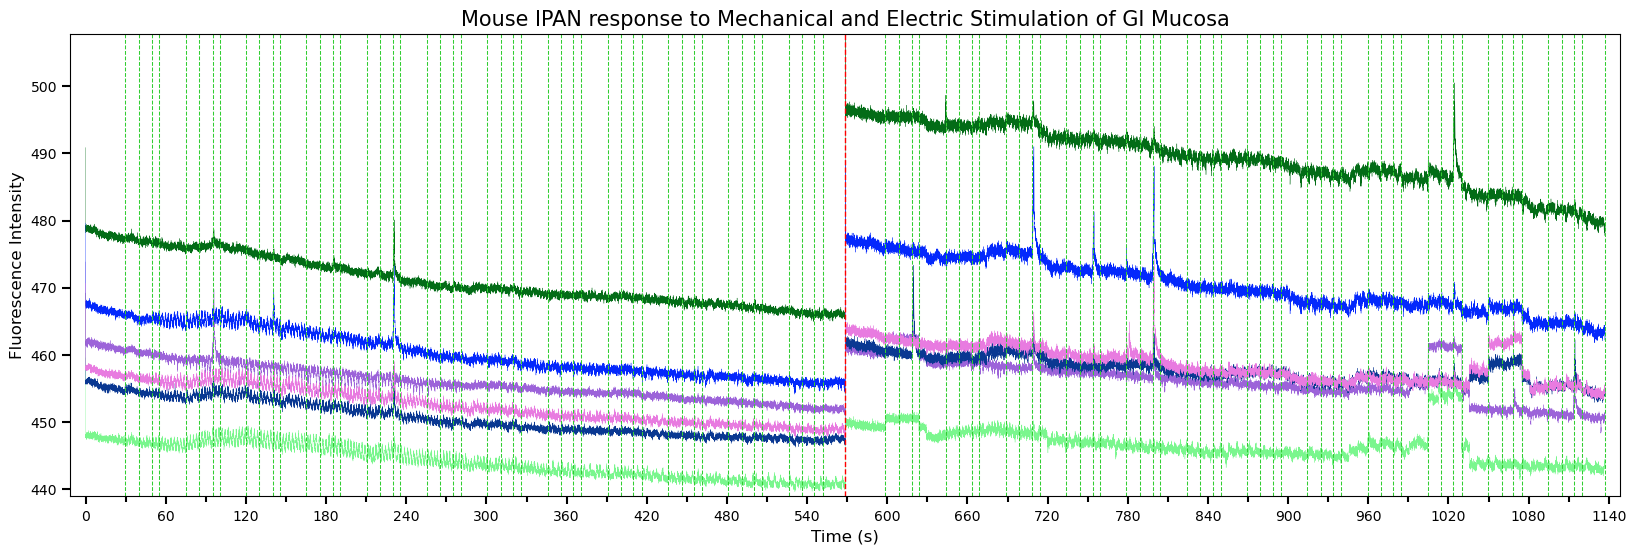

In [13]:
#Creates intensity vs time plot
allCells = plt.figure()
allCells.set_figheight(6)
allCells.set_figwidth(20)

for j in range(numCells):
        plt.plot(timeList, combinedIntensityList[j], linewidth = 0.25, c=np.random.rand(1,3))

for i in vLineList:
    plt.axvline(x = i, color = 'limegreen', label = 'axvline - full height', linestyle = "--", linewidth = 0.75)
    
plt.axvline(x = 568.65, color = 'red', label = 'axvline - full height', linestyle = "--", linewidth = 1)

#labeling the plot
plt.title('Mouse IPAN response to Mechanical and Electric Stimulation of GI Mucosa', fontdict = {'fontsize' : 15})
plt.xlabel('Time (s)', fontdict = {'fontsize' : 12})
plt.ylabel('Fluorescence Intensity', fontdict = {'fontsize' : 12})

plt.xticks(np.arange(0, 1170, step=60), fontsize=10, minor = False)
plt.xticks(np.arange(30, 1200, step=60), fontsize=10, minor = True)
plt.yticks(fontsize=10)
plt.tick_params(which='major', length=6, width=1.5)
plt.tick_params(which='minor', length=4, width=1.5)

plt.margins(x=0.01, y=0.01)

plt.show()

# fullSingleCell(j)  - j is cell number - Makes individual plots for each neuron for use in GUI- can uncomment bottom section to zoom in on specific epochs for example traces

In [14]:
# j = 0-numCells
def fullSingleCell(j):
    global indCell 
    indCell = plt.figure()
    indCell.set_figheight(4)
    indCell.set_figwidth(16)
    plt.plot(timeList, combinedIntensityList[j], linewidth = 0.25, c=np.random.rand(1,3));

    for i in vLineList:
        plt.axvline(x = i, color = 'limegreen', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)

    plt.axvline(x = 568.65, color = 'red', label = 'axvline - full height', linestyle = "--", linewidth = 0.75)

    plt.title('Cell # ' + str(j+1), fontdict = {'fontsize' : 15})
    plt.xlabel('Time (s)', fontdict = {'fontsize' : 14})
    plt.ylabel('Fluorescence Intensity', fontdict = {'fontsize' : 14})

    plt.xticks(np.arange(0, 1170, step=60), fontsize=12, minor = False)
    plt.xticks(np.arange(30, 1200, step=60), fontsize=12, minor = True)
    plt.yticks(fontsize=12)
    plt.tick_params(which='major', length=6, width=1.5)
    plt.tick_params(which='minor', length=4, width=1.5)
    plt.margins(x=0.01, y=0.01)

    
    # uncomment to zoom in on specific epochs for example traces 
    '''
    plt.plot(timeList, combinedIntensityList[j], linewidth = 1, c="black");
    indCell.set_figwidth(10)
    plt.xticks(np.arange(30, 1200, step=10), fontsize=12, minor = False)
    plt.xlim(620, 670)
    plt.ylim(460, 540)
    '''


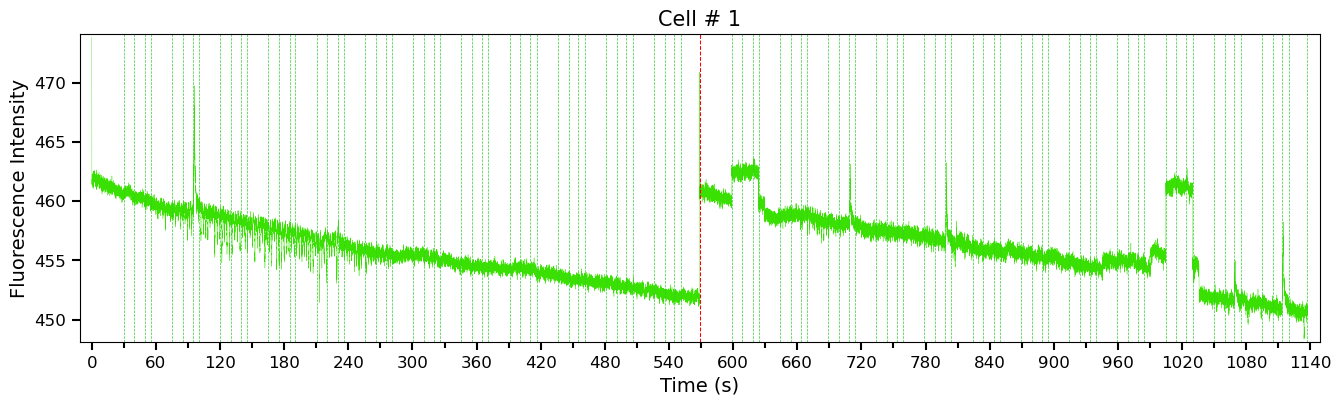

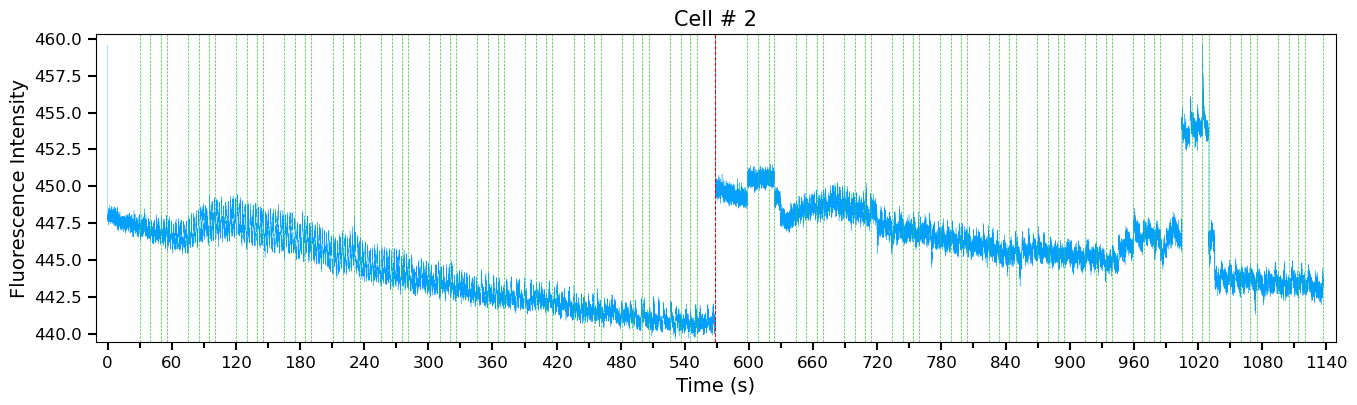

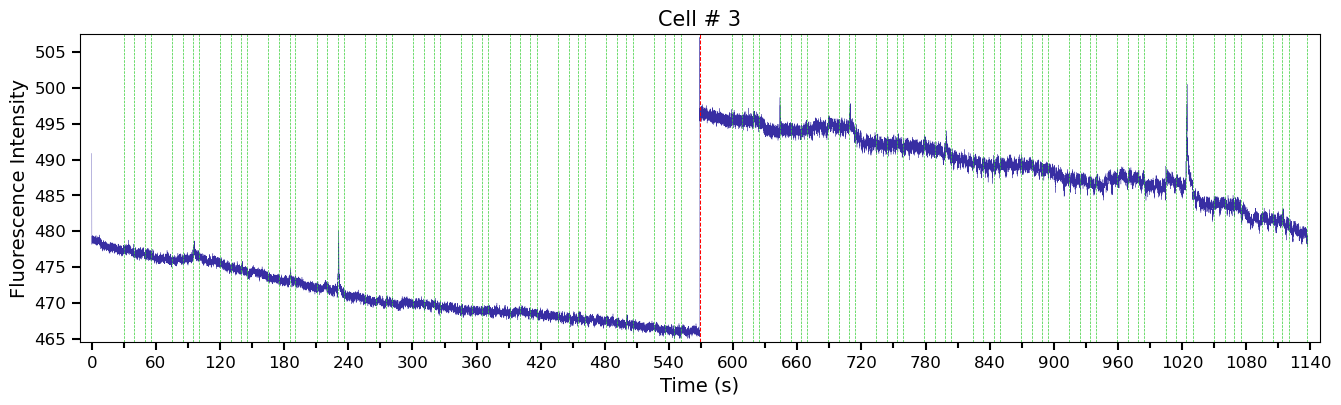

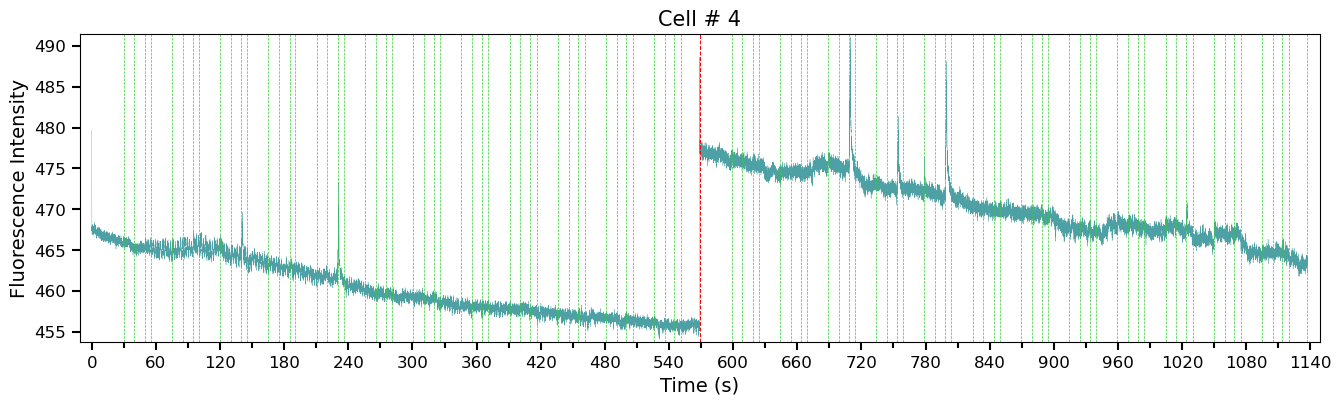

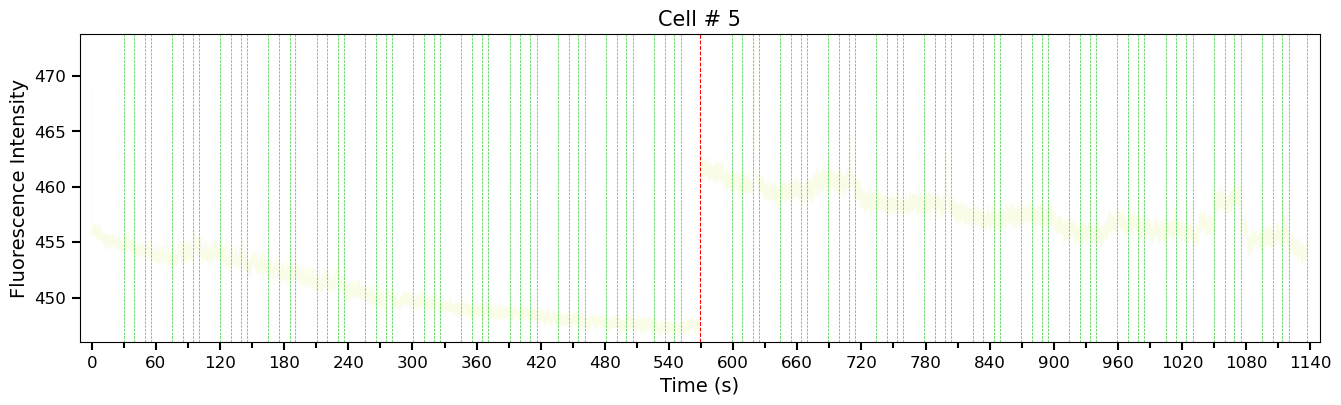

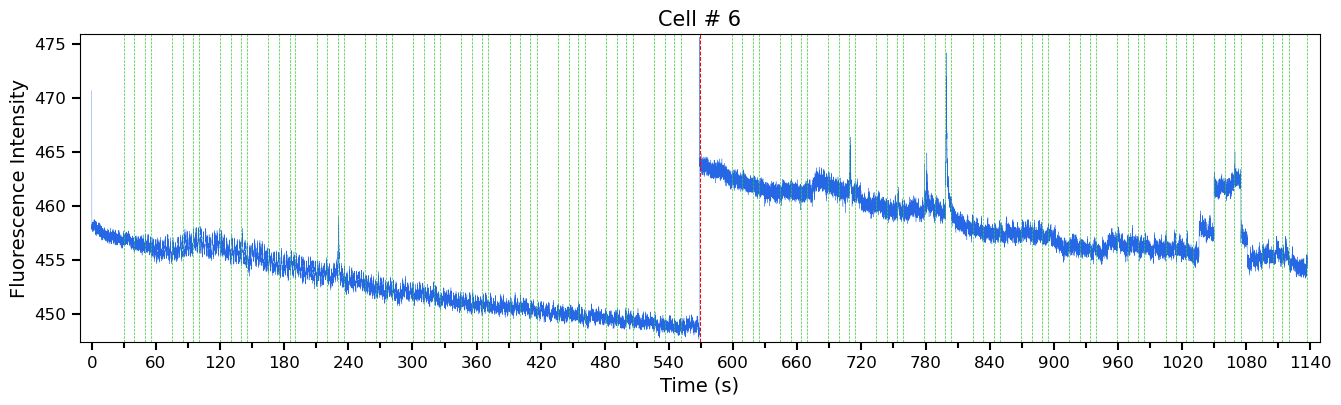

In [15]:
# print all the plots of individual cells

for k in range(numCells):
    fullSingleCell(k)

# fullCellData(i) -- i is cell index - helper function for GUI -- signal processing for a full neuron trace

Finds potential spikes, baseline of trace, corrected trace (trace - high comp noise - baseline), suggestion of whether the cell is spontaneous or not, and the traces' initialBaseline (Avg over 1st 29s). [for spontaneous: 0 = not spontaneous, 1 = if there is a spike in the 1st 30s of recording,
2 = there are more than 10 spikes in "rest times" between stimuli]

In [16]:
# i is cell index: 0-numCells
def fullCellData(i):
    
    # variables to be used throghout GUI
    global cellSpikeTimes
    global correctedTrace
    global traceBaseline
    global spontaneous
    global initialBaseline
    global highComp
    global peakList
    
    cellSpikeTimes = []
    highCompList = []
    correctedTrace = []
    traceBaseline = []
    initialBaseline = 0
    spontaneous = 0

    intensity = combinedIntensityList[i]
    
    # High-pass filtering the trace
    """ Cut-off frequency of the noise high-pass filter """
    fc = 5
    
    fsamp = (1/0.01995)  # Sampling frequency -- frameRate of the imaging
    w = fc / (fsamp / 2) # Normalize the frequency

    b, a = signal.butter(2, w,  btype='highpass', analog=False)
    highComp = signal.filtfilt(b, a, intensity, padlen = None)
    highCompList.append(highComp)
        
    baseline_fitter = Baseline(x_data=timeList)

    traceBaseline = baseline_fitter.snip(intensity, max_half_window=10, decreasing=True, smooth_half_window=1)[0]
    
    correctedTrace = intensity-traceBaseline-highComp
    
    # Finding and Marking the detected Peaks in trace
    peaks, _ = find_peaks(correctedTrace, height = 2, prominence = 2)
    peakList = list(peaks)
    if len(peakList)>500:
        peaks = []
        peaks, _ = find_peaks(correctedTrace, height = 3, prominence = 3)
        peakList = list(peaks)
    cellSpikeTimes = [] 
    
    removeList = []
    for j in range(len(peakList)):
        if int(timeList[peakList[j]]) == 568:
            removeList.append(peakList[j])
    
    for g in range(len(removeList)):
            peakList.remove(removeList[g])
            
    for j in range(len(peakList)):
        cellSpikeTimes.append(round(timeList[peakList[j]], 2))
    
    # Ca Baseline of first 30s -- the average of the first 29s (29s * 50 fps = 1450)
    InitialBaseEnd = 1450
 
    sum = 0 
    for j in range(InitialBaseEnd):
        sum = sum + traceBaseline[j]
    initialBaseline = round(sum/InitialBaseEnd,2)
    
    # Determine if cell may be Spontaneous
    sponPeaks = []
    for m in range(len(cellSpikeTimes)):
        for n in range(23):
            if cellSpikeTimes[m] > vLineList[(n*4)+3] and cellSpikeTimes[m] < vLineList[(n*4)+4]:
                sponPeaks.append(cellSpikeTimes[m])
    
    
    if cellSpikeTimes != []:  
        if cellSpikeTimes[0] < 28.5:
            spontaneous = 1
        elif len(sponPeaks)>10:
            spontaneous = 2
        else:
            spontaneous = 0

# epochAnalysis(a, j) - a is the cell index, j is the epoch index -- helper function for GUI - makes epoch plot and plot of trace - baseline of trace to look exclusively for spikes, detects possible EFS response, calculates max and min Ca baseline level during Epoch

In [17]:
# a is the cell index, j is the epoch index
def epochAnalysis(a, j):
    
    # variables to be used throghout GUI
    global epochPlot
    global spikeTrace
    global EFS
    global epochSpikeTimes
    global epochStartTime
    global step1Time
    global step2Time
    global EFStime
    global electrodeUpTime
    global epochEndTime
    global restBaseline
    global firstStep
    global endEFS
    global epochMax
    global time_epochMax
    global fullEpochMax
    global time_fullEpochMax
    EFS = 0
    
    ## Original trace and Baseline ##
    epochPlot = plt.figure()
    epochPlot.set_figheight(3)
    epochPlot.set_figwidth(14)
    
    for i in vLineList:
        plt.axvline(x = i, color = 'limegreen', label = 'axvline - full height', linestyle = "--")

    plt.axvline(x = 568.65, color = 'red', label = 'axvline - full height', linestyle = "--", linewidth = 1)
    
    plt.plot(timeList, combinedIntensityList[a], linewidth = 1, c= 'black')
    plt.plot(timeList, traceBaseline, '--', linewidth = 2, c= 'orange')
    
    plt.title('Cell # ' + str(a+1) + " " + ' Epoch # ' + str(j+1), fontdict = {'fontsize' : 12})
    plt.xlabel('Time (s)', fontdict = {'fontsize' : 12})
    plt.ylabel('Fluorescence Intensity', fontdict = {'fontsize' : 12})
    plt.xticks(np.arange(0, 1200, step=10), fontsize=10, minor = False)
    plt.xticks(np.arange(0, 1200, step=2), fontsize=10, minor = True)
    plt.yticks(fontsize=10)
    plt.tick_params(which='major', length=6, width=1.5)
    plt.tick_params(which='minor', length=4, width=1.5)
    plt.xlim(epochTimes[j][0], epochTimes[j][1])
    plt.margins(x=0.01, y=0.01)
    
    ## EFS ##
    #Finding and Marking the EFS Peaks -- has a different threshold
    step1Time = vLineList[j*4]
    step2Time = vLineList[1+(j*4)]
    EFStime = vLineList[2+(j*4)]
    electrodeUpTime = vLineList[3+(j*4)]
    
    if j == 11:
        epochEndTime = 568
    else:
        epochEndTime = vLineList[4+(j*4)]
    
    if j == 0:
        epochStartTime = 0
    if j == 12:
        epochStartTime = 568.65
    else:
        epochStartTime = vLineList[(j*4)-1] 
    
    startEFS = int((vLineList[2+(j*4)])*(1/0.01995))
    endEFS = int((vLineList[3+(j*4)])*(1/0.01995))
    
    peaks, _ = find_peaks(combinedIntensityList[a][startEFS:endEFS-50], prominence = 3)
    EFSpeakList = list(peaks)
    
    startCa = combinedIntensityList[a][startEFS]
    maxCa = max(combinedIntensityList[a][startEFS:endEFS-2])
    deltaCa = maxCa - startCa
    
    for b in range(len(EFSpeakList)-2):
        
        if EFSpeakList[b+1] - EFSpeakList[b] >= 8 and EFSpeakList[b+1] - EFSpeakList[b] <= 12 and \
            EFSpeakList[b+2] - EFSpeakList[b+1] >= 8 and EFSpeakList[b+2] - EFSpeakList[b+1] <= 12 and \
            EFSpeakList[b+2] - EFSpeakList[b] >= 17 and EFSpeakList[b+2] - EFSpeakList[b] <= 23 and \
            deltaCa >= 5:
                EFS = 1
            
    
    ## Spike Trace and potential peaks ##
    spikeTrace = plt.figure()
    spikeTrace.set_figheight(3)
    spikeTrace.set_figwidth(14)

    for i in vLineList:
        plt.axvline(x = i, color = 'limegreen', label = 'axvline - full height', linestyle = "--")
    
    correctedTrace = combinedIntensityList[a]-traceBaseline-highComp
    
    plt. plot(timeList, correctedTrace,'magenta', linewidth = 1)
    #plt. plot(timeList[1:], diff(traceBaseline),'blue', linewidth = 1)
    
    epochSpikeTimes = []
    
    for c in range(len(cellSpikeTimes)):
        sTime = cellSpikeTimes[c]
        
        if int(sTime) != 568 and sTime > epochTimes[j][0] and sTime < epochTimes[j][1]:
            plt.plot(sTime, correctedTrace[peakList[c]], "x", color='green', ms=10)
            plt.text(sTime + 2, correctedTrace[peakList[c]], sTime, fontdict = {'fontsize' : 8})
            epochSpikeTimes.append(sTime)
    
    ## De-noised and Baseline Corrected Trace with Potential Spikes Labeled ##
    plt.title('De-Noised and Baseline Corrected Trace with Potential Spikes Labeled', fontdict = {'fontsize' : 15})
    plt.xlabel('Time (s)', fontdict = {'fontsize' : 12})
    plt.ylabel('Fluorescence Intensity', fontdict = {'fontsize' : 12})
    plt.xticks(np.arange(0, 1200, step=20), fontsize=10, minor = False)
    plt.yticks(fontsize=10)
    plt.tick_params(which='major', length=6, width=1.5)
    plt.xlim(epochTimes[j][0], epochTimes[j][1])
    plt.margins(x=0.01, y=0.01)
    
    peaks2, _ = find_peaks(correctedTrace[startEFS:endEFS-50], height = 2, prominence = 2)
    PossibleEFSpeakList = list(peaks2)
    
    if EFS != 1 and len(PossibleEFSpeakList) >= 1:
        EFS = 2
    
    # Ca Baseline of epoch (10s before 1st stimulus)
    time_1 = int((step1Time-10)*(1/0.01995))
    time_2 = int((step1Time-0.5)*(1/0.01995))

    difference = time_2 - time_1
    
    sum = 0 
    for g in range(difference):
        sum = sum + traceBaseline[time_1 + g]
    restBaseline = round(sum/difference,2)
    
    # Min and Max Ca baseline level during stimulus window
    time1 = int(step1Time*(1/0.01995)) +50
    time2 = startEFS - 10
    
    baseStimWin = traceBaseline[time1:time2]
    epochMax = max(baseStimWin) 
    epochMin = min(baseStimWin)
    
    realWindow = EFStime-step1Time
    windowUsed = (time2-time1) * 0.01995
    time_epochMax = (np.argmax(baseStimWin) * 0.01995) + (realWindow- windowUsed)
    
    # full epoch min and max
    time1_2 = endEFS +50
    time2_2 = int(epochEndTime*(1/0.01995))-100
    
    restWin = traceBaseline[time1_2:time2_2]
    fullEpochMax = max(restWin) 
    time_fullEpochMax = (np.argmax(restWin) * 0.01995) + electrodeUpTime - step1Time

# changeCa(a, b) -- calculate change in Calcium baseline in an epoch -- a is the start time of baseline region, b is the end time

In [18]:
def changeCa(a,b):    
    global newBaseline
    # Ca Baseline of region determined by parameters passed into function
    startWin = int(a*(1/0.01995))
    endWin = int(b*(1/0.01995))
    difference = endWin-startWin
    
    sum = 0 
    for g in range(difference):
        sum = sum + traceBaseline[startWin + g]
    newBaseline = round(sum/difference,2) 

# find_ge() -- Find leftmost item in list a that is greater than or equal to x -- returns leftmost item or 0 of there is no such item -- for calculating latency

In [19]:
def find_ge(a, x):
    'Find leftmost item greater than or equal to x'
    i = bisect_left(a, x)
    if i != len(a):
        return a[i]
    else:
        return 0

# Create an output csv file to fill with trace data! OR comment out to add to an existing csv file

### Creates the CSV file -- Comment Out after the 1st use so that it doesn't overwrite the file!

In [20]:
'''
# field names  
fields = ['Recording Filepath', 'ROI Coords', 'GI Region', 'Plexus', 'Spontaneity', 'Responder?', 'Initial Baseline', \
            'All Approved Cell Spike Times', 'Approved Spike Times By Epoch', \
          '25s Mech Stim Window Binary', 'EFS Binary', '20s Post Stim Window Binary', \
          'Delta Ca 1st 20s', 'Delta Ca Latencies 1st 20s', 'Delta Ca Full Epoch', 'Delta Ca Latencies Full Epoch',\
          'Avg Freq Pre Stim', 'Avg Freq 25s Mech Stim Window', 'Avg Freq 20s Post Stim Window', 'Avg Freq Full 45s', \
          'Max Inst Freq 25s Mech Stim Window', 'Latency to Max Inst Freq Stim Window', 'Max Inst Freq Post Stim Window', 'Latency to Max Inst Freq Post Stim Window',\
          'Step 1 Latency to Spike in Stim Window', 'Step 2 Latency to Spike in Stim Window',\
          'Step 1 Latency to Spike in Post Stim Window', 'Step 2 Latency to Spike in Post Stim Window', 'EFS Latency to Spike in Post Stim Window'] 

# name of csv file  
#CSVfileName = "5HT Blocker Mechanical Poke Cell Data.csv"
#CSVfileName = "Avil Mechanical Poke Cell Data.csv"
#CSVfileName = "Test Output File.csv"
#CSVfileName = "Hexamethonium Mechanical Poke Cell Data.csv"
#CSVfileName = "NMU Mechanical Poke Cell Data.csv"
    
# writing to csv file  
with open(CSVfileName, 'w') as csvfile:  
    # creating a csv dict writer object  
    writer = csv.DictWriter(csvfile, fieldnames = fields)  
        
    # writing headers (field names)  
    writer.writeheader() 
    
    # Close the file object
    csvfile.close()
'''

'\n# field names  \nfields = [\'Recording Filepath\', \'ROI Coords\', \'GI Region\', \'Plexus\', \'Spontaneity\', \'Responder?\', \'Initial Baseline\',             \'All Approved Cell Spike Times\', \'Approved Spike Times By Epoch\',           \'25s Mech Stim Window Binary\', \'EFS Binary\', \'20s Post Stim Window Binary\',           \'Delta Ca 1st 20s\', \'Delta Ca Latencies 1st 20s\', \'Delta Ca Full Epoch\', \'Delta Ca Latencies Full Epoch\',          \'Avg Freq Pre Stim\', \'Avg Freq 25s Mech Stim Window\', \'Avg Freq 20s Post Stim Window\', \'Avg Freq Full 45s\',           \'Max Inst Freq 25s Mech Stim Window\', \'Latency to Max Inst Freq Stim Window\', \'Max Inst Freq Post Stim Window\', \'Latency to Max Inst Freq Post Stim Window\',          \'Step 1 Latency to Spike in Stim Window\', \'Step 2 Latency to Spike in Stim Window\',          \'Step 1 Latency to Spike in Post Stim Window\', \'Step 2 Latency to Spike in Post Stim Window\', \'EFS Latency to Spike in Post Stim Window\'] 

# Master GUI cell - calls on functions above in a semi-automated analysis -- asks for user input/confirmation to sort out clear trace artifacts -- logs curated data to csv file named above

In [21]:
from tkinter import messagebox
root = Tk()
root.title('Root Window')
root.geometry("400x400")

# if click close button GUI window -- ask for confirmation before doing so
def ask_quit():
    if messagebox.askokcancel("Quit", "You want to quit? Will interrupt kernel."):
        #root.quit()
        root.destroy()

# make a checkboxe for each detected spike in an epoch
def epochSpikeBoxes():
    global frame_1
   
    frame_1 = LabelFrame(epochWin, text="Please check boxes next to labeled spikes that are artifacts. To be removed. Leave in EFS peaks.")
    frame_1.grid(row=2, column = 0, sticky='ew', padx=5, pady=5, ipadx =5, ipady=5)
    
    global buttonDict
    buttonDict = {}
    
    buttonNameList = []
    
    # enables a select all button
    def selectAllBoxes():
        for name in buttonNameList:
            name.select()
            
    
    for f in range(len(epochSpikeTimes)):
        buttonDict["button{0}".format(f)] = StringVar()
        buttonNameList.append("button{0}".format(f))
        
    for f in range(len(epochSpikeTimes)):
        buttonNameList[f] = Checkbutton(frame_1, text=str(epochSpikeTimes[f]), variable = buttonDict["button{0}".format(f)], \
                           onvalue = epochSpikeTimes[f], offvalue = "No")
        buttonNameList[f].deselect()
        buttonNameList[f].grid(row=f//15, column=f%15)
    
    selectAll = Button(frame_1, text="Select All", command = selectAllBoxes)
    selectAll.grid(row = len(epochSpikeTimes)//10 +1, column = 1)
    
    if(len(epochSpikeTimes)) == 0:
        showSomething = Label(frame_1, text = "  ")
        showSomething.grid(row=0, column=0)
        
# If spikes occur in the time following the EFS, this ask the used to confirm if it is a clear 5 Hz response or not  
def checkEFS(cell_index, nextEpoch_index):
    global EFSapproved
    global frame_EFS
    frame_EFS = LabelFrame(epochWin, text="Is there a clear 5 Hz EFS response?")
    if EFS == 1 or EFS == 2:
        frame_EFS.grid(row=3, column = 1, sticky='ew', padx=5, pady=5, ipadx=5, ipady=5)
        
        button_toNextEpoch = Button(epochWin, text="       Confirm EFS or Ca Baseline before continuing       ", state = DISABLED, command = lambda: nextEpoch(cell_index, nextEpoch_index))
        button_toNextEpoch.grid(row=3,column=2)
        
        EFSvar = tk.StringVar()
        
        def clicked():
            EFSButton.grid_forget()
            
            global EFSapproved
            EFSapproved = int(EFSvar.get())
            EFS_list.append(EFSapproved)
            
            checkBaseline(cell_index, nextEpoch_index)
            
        if EFS == 1:
            EFSvar.set("1")
        else:
            EFSvar.set("2")
        r1 = Radiobutton(frame_EFS, text = "Yes", variable = EFSvar, value = "1")
        r2 = Radiobutton(frame_EFS, text = "No", variable = EFSvar, value = "0")
        r3 = Radiobutton(frame_EFS, text = "Weak response but clearly from EFS", variable = EFSvar, value = "2")
        r1.grid(row=0, column=0, pady=10, sticky = W)
        r2.grid(row=1, column=0, pady=10, sticky = W)
        r3.grid(row=2, column=0, pady=10, sticky = W)
        
        EFSButton = Button(frame_EFS, text="Submit", command = clicked)
        EFSButton.grid(row=0, column=1)

    else:
        EFSapproved = 0
        EFS_list.append(EFSapproved)
        checkBaseline(cell_index, nextEpoch_index)

# if there is a change in Ca level after electrode is removed that is greater than that during the stimulus window, ask user whether it is from an artifact or not     
def fullWindowCaBaseline(cell_index, nextEpoch_index):
    global button_blocker
    global frame_changeCa
    global frame_FullBaseline 
    global button_nextEpoch
    
    frame_Baseline.grid_forget()
    
    frame_changeCa = LabelFrame(epochWin, text="The Ca Level in the Rest window > Stim window. How to proceed?")
    frame_FullBaseline = LabelFrame(epochWin, text="Please specify a new Baseline Region for the Post-Stimulation Period.")
    
    if fullEpochMax > epochMax and max(diff(traceBaseline)[int(electrodeUpTime*(1/0.01995))-25:int(epochEndTime*(1/0.01995))-250]) > 0.05:
        frame_changeCa.grid(row=2, column = 2, sticky='ew', padx=5, pady=5, ipadx=5, ipady=5)
        
        button_blocker = Button(epochWin, text="       Confirm Ca Change before continuing       ", state = DISABLED, command = lambda: nextEpoch(cell_index, nextEpoch_index))
        button_blocker.grid(row=3,column=2)
        
        CaBasevar = tk.StringVar()
        
        def clicked():
            global button_blocker
            global frame_FullBaseline
            global button_nextEpoch
            CaButton.grid_forget()
            button_blocker.grid_forget()
            
            if CaBasevar.get() == "1":
                fullEpochDeltaCa.append(round(fullEpochMax - epochBaseline,2))
                fullEpochdeltaCaLatencies.append(round(time_fullEpochMax,2))
  
                # skip over epochs with no spikes
                if len(epochSpikeTimes) == 0:
                    button_nextEpoch = Button(epochWin, text="Submit and Continue to Next Epoch", command = lambda: nextEpoch(cell_index, nextEpoch_index))
                    if nextEpoch_index == 24:
                        TransitionFunc(cell_index)
                        #submitCell(cell_index)
                    else:
                        nextEpoch(cell_index, nextEpoch_index)

                else:
                    button_nextEpoch = Button(epochWin, text="Submit and Continue to Next Epoch", command = lambda: nextEpoch(cell_index, nextEpoch_index))
                    if nextEpoch_index == 24:
                        #button_nextEpoch = Button(epochWin, text="             Submit to finish this Cell           ", command = lambda: submitCell(cell_index))
                        button_nextEpoch = Button(epochWin, text="             Submit to finish this Cell           ", command = lambda: TransitionFunc(cell_index))
                    button_nextEpoch.grid(row=3,column=2)

            elif CaBasevar.get() == "2":
                # sliders
                frame_FullBaseline.grid(row=2, column = 1, sticky='ew', padx=5, pady=5, ipadx=5, ipady=5)
                instructions = Label(frame_FullBaseline, text="Select Beginning and Ending times of Region to make baseline")
                instructions.grid(row=0,column=0)

                label_1 = Label(frame_FullBaseline, text="Beginning Time of Region")
                label_1.grid(row=1,column=0)
                
                # submits the 1st user entered time to determine an appropriate Ca Baseline for change in Ca calculation
                def submitTimes():
                    global button_nextEpoch
                    
                    submitButton_2.grid_forget()
                    changeCa(horizontal_1.get(),horizontal_2.get())
                    if (fullEpochMax - newBaseline) > (epochMax - epochBaseline):
                        fullEpochDeltaCa.append(round(fullEpochMax - newBaseline,2))
                        fullEpochdeltaCaLatencies.append(round(time_fullEpochMax,2))
                    else:
                        fullEpochDeltaCa.append(round(epochMax - epochBaseline,2))
                        fullEpochdeltaCaLatencies.append(round(time_epochMax,2))

                            # skip over epochs with no spikes
                    if len(epochSpikeTimes) == 0:
                        button_nextEpoch = Button(epochWin, text="Submit and Continue to Next Epoch", command = lambda: nextEpoch(cell_index, nextEpoch_index))
                        if nextEpoch_index == 24:
                            TransitionFunc(cell_index)
                        else:
                            nextEpoch(cell_index, nextEpoch_index)
                    
                    else:
                        button_nextEpoch = Button(epochWin, text="Submit and Continue to Next Epoch", command = lambda: nextEpoch(cell_index, nextEpoch_index))
                        if nextEpoch_index == 24:
                            button_nextEpoch = Button(epochWin, text="             Submit to finish this Cell           ", command = lambda: TransitionFunc(cell_index))
                        button_nextEpoch.grid(row=3,column=2)

                # submits the 2nd user entered time to determine an appropriate Ca Baseline for change in Ca calculation
                def Trigger_2nd():
                    global horizontal_2
                    global submitButton_2
                    submitButton.grid_forget()
                    label_2 = Label(frame_FullBaseline, text="Ending Time of Region")
                    label_2.grid(row=1,column=1)
                    horizontal_2 = Scale(frame_FullBaseline, from_=horizontal_1.get()+0.1, to=epochEndTime, resolution=0.1, orient=HORIZONTAL)
                    horizontal_2.grid(row=2,column=1)
                    submitButton_2 = Button(frame_FullBaseline, text = "Submit Both", command = submitTimes)
                    submitButton_2.grid(row=3, column=0)

                horizontal_1 = Scale(frame_FullBaseline, from_= electrodeUpTime, to=epochEndTime, resolution=0.1, orient=HORIZONTAL)
                horizontal_1.grid(row=2,column=0)

                submitButton = Button(frame_FullBaseline, text = "Submit", command = Trigger_2nd)
                submitButton.grid(row=3, column=0)
                
            else:
                fullEpochDeltaCa.append(round(epochMax - epochBaseline,2))
                fullEpochdeltaCaLatencies.append(round(time_epochMax,2))
    
                # skip over epochs with no spikes
                if len(epochSpikeTimes) == 0:
                    button_nextEpoch = Button(epochWin, text="Submit and Continue to Next Epoch", command = lambda: nextEpoch(cell_index, nextEpoch_index))
                    if nextEpoch_index == 24:
                        TransitionFunc(cell_index)
                    else:
                        nextEpoch(cell_index, nextEpoch_index)
                    
                else:
                    button_nextEpoch = Button(epochWin, text="Submit and Continue to Next Epoch", command = lambda: nextEpoch(cell_index, nextEpoch_index))
                    if nextEpoch_index == 24:
                        button_nextEpoch = Button(epochWin, text="             Submit to finish this Cell           ", command = lambda: TransitionFunc(cell_index))
                    button_nextEpoch.grid(row=3,column=2)
            
        CaBasevar.set("0")
        r1 = Radiobutton(frame_changeCa, text = "Discard, there is an artifact suggesting it is from stage movement.", variable = CaBasevar, value = "0")
        r2 = Radiobutton(frame_changeCa, text = "Use the same baseline!", variable = CaBasevar, value = "1")
        r3 = Radiobutton(frame_changeCa, text = "Check with a new baseline if it's greater.", variable = CaBasevar, value = "2")
        r1.grid(row=0, column=0, pady=10, sticky = W)
        r2.grid(row=1, column=0, pady=10, sticky = W)
        r3.grid(row=2, column=0, pady=10, sticky = W)
        
        CaButton = Button(frame_changeCa, text="Submit", command = clicked)
        CaButton.grid(row=0, column=1)

    else:
        if fullEpochMax > epochMax:
            fullEpochDeltaCa.append(round(fullEpochMax - epochBaseline,2))
            fullEpochdeltaCaLatencies.append(round(time_fullEpochMax,2))
        else:
            fullEpochDeltaCa.append(round(epochMax - epochBaseline,2))
            fullEpochdeltaCaLatencies.append(round(time_epochMax,2))
    

        # skip over epochs with no spikes
        if len(epochSpikeTimes) == 0:
            button_nextEpoch = Button(epochWin, text="Submit and Continue to Next Epoch", command = lambda: nextEpoch(cell_index, nextEpoch_index))
            if nextEpoch_index == 24:
                    TransitionFunc(cell_index)
            else:
                nextEpoch(cell_index, nextEpoch_index)

        else:
            button_nextEpoch = Button(epochWin, text="Submit and Continue to Next Epoch", command = lambda: nextEpoch(cell_index, nextEpoch_index))
            if nextEpoch_index == 24:
                button_nextEpoch = Button(epochWin, text="             Submit to finish this Cell           ", command = lambda: TransitionFunc(cell_index))
            button_nextEpoch.grid(row=3,column=2)

# if there is a detected jump in fluorescence (stimulus artifact), acts the user to specify a new baseline for the stimulus window        
def checkBaseline(cell_index, nextEpoch_index):
    global baseLabel
    global frame_Baseline
    global epochBaseline
    
    frame_Baseline = LabelFrame(epochWin, text="Please specify a new Baseline Region for the Mechanical Stim Region")
    
    firstStep = int(vLineList[(nextEpoch_index-1)*4]*(1/0.01995))
    
    if max(diff(traceBaseline)[firstStep-25:firstStep+50]) > 0.05 and min(diff(traceBaseline)[endEFS -50:endEFS +25]) < -0.05:
        frame_Baseline.grid(row=2, column = 1, sticky='ew', padx=5, pady=5, ipadx=5, ipady=5)
        
        # sliders
        instructions = Label(frame_Baseline, text="Select Beginning and Ending times of Region to make baseline")
        instructions.grid(row=0,column=0)


        label_1 = Label(frame_Baseline, text="Beginning Time of Region")
        label_1.grid(row=1,column=0)
        
        # submits the 1st user entered time to determine an appropriate Ca Baseline
        def submitTimes():
            global epochBaseline
            
            submitButton_2.grid_forget()
            changeCa(horizontal_1.get(),horizontal_2.get())
            epochBaseline = newBaseline
            deltaCaList.append(round(epochMax - newBaseline,2))
            deltaCaLatencies.append(round(time_epochMax,2))
            
            fullWindowCaBaseline(cell_index, nextEpoch_index)
        
        # submits the 2nd user entered time to determine an appropriate Ca Baseline
        def Trigger_2nd():
            global horizontal_2
            global submitButton_2
            submitButton.grid_forget()
            label_2 = Label(frame_Baseline, text="Ending Time of Region")
            label_2.grid(row=1,column=1)
            horizontal_2 = Scale(frame_Baseline, from_=horizontal_1.get()+0.1, to=EFStime, resolution=0.1, orient=HORIZONTAL)
            horizontal_2.grid(row=2,column=1)
            submitButton_2 = Button(frame_Baseline, text = "Submit Both", command = submitTimes)
            submitButton_2.grid(row=3, column=0)

        horizontal_1 = Scale(frame_Baseline, from_= step1Time, to=EFStime, resolution=0.1, orient=HORIZONTAL)
        horizontal_1.grid(row=2,column=0)

        submitButton = Button(frame_Baseline, text = "Submit", command = Trigger_2nd)
        submitButton.grid(row=3, column=0)

    else:
        deltaCaList.append(round(epochMax - restBaseline,2))
        deltaCaLatencies.append(round(time_epochMax,2))
        epochBaseline = restBaseline
        fullWindowCaBaseline(cell_index, nextEpoch_index)


def initiateLists():
    
    # the arrays holding data that will be added to the csv file
    global EFS_list
    global deltaCaList
    global deltaCaLatencies
    global fullEpochDeltaCa
    global fullEpochdeltaCaLatencies
    global approvedEpochSpikeTimes
    global AvgFreqPreStim
    global AvgFreqMechStimWin
    global AvgFreq20sPostStim
    global AvgFreq45sWin
    global StimWinBinary
    global RestWinBinary
    global MaxInstFreqStimWin
    global MaxInstFreqPostStim
    global Latency_MaxInstFreqStimWin
    global Latency_MaxInstFreqPostStim
    global Step1Latency
    global Step2Latency
    global Step1LatencyRestWin
    global Step2LatencyRestWin
    global EFSLatencyRestWin
        
        
    EFS_list = []
    deltaCaList = []
    deltaCaLatencies = []
    fullEpochDeltaCa = []
    fullEpochdeltaCaLatencies = []
    approvedEpochSpikeTimes = []
    StimWinBinary = []
    RestWinBinary = []
    Step1Latency = []
    Step2Latency = []
    Step1LatencyRestWin = []
    Step2LatencyRestWin = []
    EFSLatencyRestWin = []
    AvgFreqPreStim = []
    AvgFreqMechStimWin = []
    AvgFreq20sPostStim = []
    AvgFreq45sWin = []
    MaxInstFreqStimWin = []
    MaxInstFreqPostStim = []
    Latency_MaxInstFreqStimWin = []
    Latency_MaxInstFreqPostStim = []
    
# variables for each epoch that will be appended to a particular list to be logged    
def spikeDataExtract():
    global approvedEpochSpikeTimes
    global epochSpikeTimes
    global AvgFreqPreStim
    global AvgFreqMechStimWin
    global AvgFreq20sPostStim
    global AvgFreq45sWin
    global StimWinBinary
    global RestWinBinary
    global MaxInstFreqStimWin
    global MaxInstFreqPostStim
    global Latency_MaxInstFreqStimWin
    global Latency_MaxInstFreqPostStim
    global Step1Latency
    global Step2Latency
    global Step1LatencyRestWin
    global Step2LatencyRestWin
    global EFSLatencyRestWin
    
    
    ## Remove spikes that were checked in GUI and EFS spikes
    
    removeEFSspikes = []
    if EFSapproved == 1 or EFSapproved == 2:
        for time in epochSpikeTimes:
            if time >= EFStime - 0.2 and time <= EFStime + 3:
                removeEFSspikes.append(time)
        for spike in removeEFSspikes:
            epochSpikeTimes.remove(spike)
            cellSpikeTimes.remove(spike)
    
    checkedList = []
    for entry in buttonDict:
        if buttonDict[entry].get() != "No":
            checkedList.append(buttonDict[entry].get())
    for thing in checkedList:
        if float(thing) not in removeEFSspikes:
            epochSpikeTimes.remove(float(thing))
            cellSpikeTimes.remove(float(thing))
    approvedEpochSpikeTimes.append(epochSpikeTimes)
    
    
    ## Avg Freq
    
    preStimSpikes = []
    mechStimWinSpikes = []
    postStimSpikes = []
    spikes45s = []
    
    for item in epochSpikeTimes:
        if item < step1Time:
             preStimSpikes.append(item)
        elif item > step1Time and item < electrodeUpTime:
            mechStimWinSpikes.append(item)
        elif item > electrodeUpTime:
            postStimSpikes.append(item)
    
    for item in epochSpikeTimes:
        if item > step1Time:
            spikes45s.append(item)
            
    AvgFreqPreStim.append(round(len(preStimSpikes) / (step1Time-epochStartTime),2))
    AvgFreqMechStimWin.append(round(len(mechStimWinSpikes) / (electrodeUpTime-step1Time),2))
    AvgFreq20sPostStim.append(round(len(postStimSpikes) / (epochEndTime-electrodeUpTime),2))
    AvgFreq45sWin.append(round(len(spikes45s) / (epochEndTime-step1Time),2))
      
        
    ## Mech Binary Lists
    
    if mechStimWinSpikes != [] or deltaCaList[-1] > 10:
        StimWinBinary.append(1)
    else:
        StimWinBinary.append(0)
    
    if fullEpochDeltaCa[-1] > deltaCaList[-1]:
        delCa = fullEpochDeltaCa[-1]
    else:
        delCa = 0
    
    if postStimSpikes != [] or delCa > 10:
        RestWinBinary.append(1)
    else:
        RestWinBinary.append(0)
    
    
     ## Instantaneous Freq
    
    if mechStimWinSpikes == [] or len(mechStimWinSpikes) == 1:
        MaxInstFreqStimWin.append(0)
        Latency_MaxInstFreqStimWin.append(0)
            
    else:

        maxFreq = 0
        maxIndex = 0
        
        for e in range(len(mechStimWinSpikes)-1):
            timeDiff = mechStimWinSpikes[e+1]-mechStimWinSpikes[e]
            instFreq = 1/timeDiff
            if instFreq > maxFreq:
                maxFreq = instFreq
                maxIndex = e+1

        MaxInstFreqStimWin.append(round(maxFreq,2))
        Latency_MaxInstFreqStimWin.append(round(mechStimWinSpikes[maxIndex]-step1Time,2))
    
        
    if postStimSpikes == [] or len(postStimSpikes) == 1:
        MaxInstFreqPostStim.append(0)
        Latency_MaxInstFreqPostStim.append(0)    
    
    else:

        maxFreq = 0
        maxIndex = 0
        
        for e in range(len(postStimSpikes)-1):
            timeDiff = postStimSpikes[e+1]-postStimSpikes[e]
            instFreq = 1/timeDiff
            if instFreq > maxFreq:
                maxFreq = instFreq
                maxIndex = e+1

        MaxInstFreqPostStim.append(round(maxFreq,2))
        Latency_MaxInstFreqPostStim.append(round(postStimSpikes[maxIndex] - electrodeUpTime,2))
        

    ## Latency to Spikes
    
    FirstPeakAfterStep1 = find_ge(mechStimWinSpikes, step1Time)
    FirstPeakAfterStep2 = find_ge(mechStimWinSpikes, step2Time)
    FirstInRestWin = find_ge(postStimSpikes, electrodeUpTime)
    
    if FirstPeakAfterStep1 == 0:
        Step1Latency.append(0)
    else:
        Step1Latency.append(round(FirstPeakAfterStep1-step1Time,2))
        
    if FirstPeakAfterStep2 == 0:
        Step2Latency.append(0)
    else:
        Step2Latency.append(round(FirstPeakAfterStep2-step2Time,2))

    if FirstInRestWin == 0:
        Step1LatencyRestWin.append(0)
        Step2LatencyRestWin.append(0)
        EFSLatencyRestWin.append(0)
    else:
        Step1LatencyRestWin.append(round(FirstInRestWin-step1Time,2))
        Step2LatencyRestWin.append(round(FirstInRestWin-step2Time,2))
        EFSLatencyRestWin.append(round(FirstInRestWin-EFStime,2))
    
# opens GUI window displaying the trace of the first cell to be analyzed        
def firstCell():
    global status
    global button_nextCell
    global canvas
    global cellCounter
    global fileCellNum
    
    cellCounter = 1
    
    first_button.destroy()
    submit_button.destroy()
    info_label.destroy()
    drop1.destroy()
    drop2.destroy()
    answer_label.destroy()
    
    root.geometry("1600x620")
    
    fullSingleCell(0)
    fullCellData(0)
    canvas = FigureCanvasTkAgg(indCell, master= root) # Convert the Figure to a tkinter widget
    canvas.get_tk_widget().grid(row=0,column=0,columnspan=3) # Show the widget on the screen
    
    button_ToFirstEpoch = Button(root, text="Click to continue to Epoch data", command = firstCellFirstEpoch)
    button_ToFirstEpoch.grid(row=2,column=2)
    
    status = Label(root, text="Image 1 of " + str(numCells), bd=1, relief = SUNKEN, anchor=E)
    status.grid(row=4,column=0,columnspan=3,sticky=W+E)

# Opens GUI window for the 1st Epoch of the 1st cell, showing plots, check boxes for detected spikes, and EFS or Ca Baseline checks if needed 
def firstCellFirstEpoch():
    global epochWin
    
    epochWin = Toplevel()
    epochWin.title("Epoch Window")
    epochWin.geometry("1650x1200")
    
    initiateLists()
    
    epochAnalysis(0, 0)
    epochSpikeBoxes()
    
    checkEFS(0,1)

    canvas = FigureCanvasTkAgg(epochPlot, master= epochWin) # Convert the trace plot to a tkinter widget
    canvas.get_tk_widget().grid(row=0,column=0,columnspan=3) # Show the widget on the screen
    canvas = FigureCanvasTkAgg(spikeTrace, master= epochWin)
    canvas.get_tk_widget().grid(row=1,column=0,columnspan=3) 
    
    status = Label(epochWin, text="Epoch 1 of 24", bd=1, relief = SUNKEN, anchor=E)
    status.grid(row=4,column=0,columnspan=3,sticky=W+E)
    
# Opens GUI window for the 1st Epoch any cell after the 1st, showing plots, check boxes for detected spikes, and EFS or Ca Baseline checks if needed     
def firstEpoch(cell_index):
    global epochWin

    epochWin = Toplevel()
    epochWin.title("Epoch Window")
    epochWin.geometry("1650x1200")
    
    initiateLists()
    
    epochAnalysis(cell_index, 0)
    epochSpikeBoxes()
    
    checkEFS(cell_index, 1)

    canvas = FigureCanvasTkAgg(epochPlot, master= epochWin)
    canvas.get_tk_widget().grid(row=0,column=0,columnspan=3) 
    canvas = FigureCanvasTkAgg(spikeTrace, master= epochWin) 
    canvas.get_tk_widget().grid(row=1,column=0,columnspan=3)
    
    status = Label(epochWin, text="Epoch 1 of 24", bd=1, relief = SUNKEN, anchor=E)
    status.grid(row=4,column=0,columnspan=3,sticky=W+E)

# Opens GUI window for the any Epoch after the 1st, but only if there is user action needed (such as spikes detected that need to be sorted). Shows plots, check boxes for detected spikes, and EFS or Ca Baseline checks if needed   
def nextEpoch(cell_index, epoch_index):

    spikeDataExtract()
    
    frame_1.grid_forget()
    frame_EFS.grid_forget()
    frame_FullBaseline.grid_forget()
    frame_changeCa.grid_forget()
    button_nextEpoch.grid_forget()
    plt.close(epochPlot)
    plt.close(spikeTrace)
    
    epochAnalysis(cell_index, epoch_index)
    epochSpikeBoxes()
    
    checkEFS(cell_index,epoch_index + 1)
                
    canvas = FigureCanvasTkAgg(epochPlot, master= epochWin) 
    canvas.get_tk_widget().grid(row=0,column=0,columnspan=3)
    canvas = FigureCanvasTkAgg(spikeTrace, master= epochWin) 
    canvas.get_tk_widget().grid(row=1,column=0,columnspan=3) 
    
    status = Label(epochWin, text="Epoch " + str(epoch_index +1) + " of 24", bd=1, relief = SUNKEN, anchor=E)
    status.grid(row=4,column=0,columnspan=3,sticky=W+E)

# Closes GUI windows/forgets plots when moving on to the next GUI window    
def TransitionFunc(cell_index):    
    spikeDataExtract()
    
    frame_1.grid_forget()
    frame_EFS.grid_forget()
    plt.close(epochPlot)
    plt.close(spikeTrace)
    epochWin.destroy()    
    
    checkSpon(cell_index)
    
# prompts user to categorize cell. Automatcally labeled as non-responder if not responses. Otherwise suggests if it could be a spontaneous cell.    
def checkSpon(cell_index):
    global Spon
    global Responder
    global SponWin

    SponWin = Toplevel()
    SponWin.title('Confirm Spontaneity')
    
    if spontaneous == 0:
        sponLabel = Label(SponWin, text = "Cell is Quiescent. Does this seem right?")
    elif spontaneous == 1:
        sponLabel = Label(SponWin, text = "Cell is Spontaneous. Does this seem right?")
    else:
        sponLabel = Label(SponWin, text = "This cell seems to start quiescent but becomes spontaneous. Does this seem right?")
    sponLabel.grid(row = 1, column = 0)
    
    pizza = tk.StringVar()
    pizza.set(str(spontaneous))
    
    blockerButton = Button(root, text="Please confirm Spontaneity first, then Click to Submit Cell", state = DISABLED)
    blockerButton.grid(row=2,column=2)
    
    def confirmSpon():
        global sponLabel2
        global Spon 
        global Responder
        Spon = int(pizza.get())
        
        if Spon == 0:
            sponLabel2 = Label(root, text = "You chose that this cell is Quiescent.")
        elif Spon == 1:
            sponLabel2 = Label(root, text = "You chose that this cell is Spontaneous.")
        else:
            sponLabel2 = Label(root, text = "You chose that this cell starts Quiescent but becomes Spontaneous.")
        sponLabel2.grid(row = 2, column = 0)
        
        if Spon == 1 or Spon == 2:
            Responder = "Spontaneous Cell"
        elif any(i == 1 for i in EFS_list) is True and cellSpikeTimes != []:
            Responder = "Mech and EFS Responder"
        elif cellSpikeTimes != []:
            Responder = "Mech Responder only"
        elif any(i == 1 for i in EFS_list) is True:
            Responder = "EFS Responder only"
        else:
            Responder = "No"
        
        blockerButton.destroy()
        submitCell(cell_index)
    
    r1 = Radiobutton(SponWin, text = "Option 0: Quiescent (NOT Spontaneous)", variable = pizza, value = "0")
    r2 = Radiobutton(SponWin, text = "Option 1: Spontaneous", variable = pizza, value = "1")
    r3 = Radiobutton(SponWin, text = "Option 2: Starts Quiescent then becomes Spontaneous", variable = pizza, value = "2")

    r1.grid(row=1, column=1, pady=10, sticky = W)
    r2.grid(row=2, column=1, pady=10, sticky = W)
    r3.grid(row=3, column=1, pady=10, sticky = W)

    
    myButton2 = Button(SponWin, text="Submit choice", command = confirmSpon)
    myButton2.grid(row=1, column=3, padx=10)


# In the CSV file named above, adds the current cell's data to the next row in the csv file. Organized as a dictionary so that specific variables can be easily retrieved.    
def submitCell(cell_index):
    global cellCounter

    SponWin.destroy()
    
    # my data rows as dictionary objects  
    mydict =[{'Recording Filepath': filename1[72:], 'ROI Coords': regionCoordList[cell_index], 'GI Region': selectedRegion.get(), 'Plexus': selectedPlexus.get(), 'Spontaneity': Spon,\
              'Responder?': Responder, 'Initial Baseline': initialBaseline, 'All Approved Cell Spike Times': cellSpikeTimes, 'Approved Spike Times By Epoch': approvedEpochSpikeTimes,\
              '25s Mech Stim Window Binary': StimWinBinary, 'EFS Binary': EFS_list, '20s Post Stim Window Binary': RestWinBinary,\
              'Delta Ca 1st 20s': deltaCaList, 'Delta Ca Latencies 1st 20s': deltaCaLatencies, 'Delta Ca Full Epoch': fullEpochDeltaCa, 'Delta Ca Latencies Full Epoch': fullEpochdeltaCaLatencies,\
              'Avg Freq Pre Stim': AvgFreqPreStim, 'Avg Freq 25s Mech Stim Window': AvgFreqMechStimWin, 'Avg Freq 20s Post Stim Window': AvgFreq20sPostStim, 'Avg Freq Full 45s': AvgFreq45sWin, \
              'Max Inst Freq 25s Mech Stim Window': MaxInstFreqStimWin, 'Latency to Max Inst Freq Stim Window': Latency_MaxInstFreqStimWin, 'Max Inst Freq Post Stim Window': MaxInstFreqPostStim,\
              'Latency to Max Inst Freq Post Stim Window': Latency_MaxInstFreqPostStim, 'Step 1 Latency to Spike in Stim Window': Step1Latency,\
              'Step 2 Latency to Spike in Stim Window': Step2Latency, 'Step 1 Latency to Spike in Post Stim Window': Step1LatencyRestWin, \
              'Step 2 Latency to Spike in Post Stim Window': Step2LatencyRestWin,'EFS Latency to Spike in Post Stim Window': EFSLatencyRestWin}]
    
    # field names  
    fields = ['Recording Filepath', 'ROI Coords', 'GI Region', 'Plexus', 'Spontaneity', 'Responder?', 'Initial Baseline', \
            'All Approved Cell Spike Times', 'Approved Spike Times By Epoch', \
          '25s Mech Stim Window Binary', 'EFS Binary', '20s Post Stim Window Binary', \
          'Delta Ca 1st 20s', 'Delta Ca Latencies 1st 20s', 'Delta Ca Full Epoch', 'Delta Ca Latencies Full Epoch',\
          'Avg Freq Pre Stim', 'Avg Freq 25s Mech Stim Window', 'Avg Freq 20s Post Stim Window', 'Avg Freq Full 45s', \
          'Max Inst Freq 25s Mech Stim Window', 'Latency to Max Inst Freq Stim Window', 'Max Inst Freq Post Stim Window', 'Latency to Max Inst Freq Post Stim Window',\
          'Step 1 Latency to Spike in Stim Window', 'Step 2 Latency to Spike in Stim Window',\
          'Step 1 Latency to Spike in Post Stim Window', 'Step 2 Latency to Spike in Post Stim Window', 'EFS Latency to Spike in Post Stim Window'] 
    
    # writing to csv file  
    with open(CSVfileName, 'a') as csvfile:  
         
        writer = csv.DictWriter(csvfile, fieldnames = fields)  
        writer.writerows(mydict)
        csvfile.close()
    
    if cellCounter == numCells:
        button_nextCell = Button(root, text="                                          End Analysis                                               ", command = endAnalysis)
    else:
        button_nextCell = Button(root, text="                                 Continue to the Next Cell                               ", command = lambda: nextCell(cellCounter))
    button_nextCell.grid(row=2,column=2)
  
 # If not the final neuron in the recording file, initiate analysis for the next cell. Shows individual cell's trace
def nextCell(cell_index):
    global status
    global button_nextCell
    global canvas
    global cellCounter
    global fileCellNum
    
    plt.close(indCell)
    
    sponLabel2.grid_forget()
    
    cellCounter = cell_index + 1
    fullSingleCell(cell_index)
    fullCellData(cell_index)
    canvas = FigureCanvasTkAgg(indCell, master= root) # Convert the Figure to a tkinter widget
    canvas.get_tk_widget().grid(row=0,column=0,columnspan=3) # Show the widget on the screen
    
    button_nextCell = Button(root, text="                             Click to continue to Epoch data                            ", command = lambda: firstEpoch(cellCounter-1))
    button_nextCell.grid(row=2,column=2)
    
    # update status bar
    status = Label(root, text="Image "+ str(cell_index+1) + " of " + str(numCells), bd=1, relief = SUNKEN, anchor=E)
    status.grid(row=4,column=0,columnspan=3,sticky=W+E)

 # closes GUI windows when done with all the neurons in the recording
def endAnalysis():
    
    plt.close(indCell)
    root.destroy()

 # prompts user to categorize the recording as SMP vs MYP   
def show():
    global answer_label
    global first_button
    
    answer_label = Label(root, text = selectedRegion.get() + " "+ selectedPlexus.get())
    answer_label.grid(row=4, column=0, pady=10)  
    
    first_button = Button(root, text = "Submit and begin Analysis!", command = firstCell)
    first_button.grid(row=5, column=0)  

info_label = Label(root, text = "Please select the GI region and enteric plexus before continuing.")
info_label.grid(row=0, column=0, pady=10)    
    
RegionOptions = [
    "Jejunum", 
    "Ileum",
    "Colon"
]    

selectedRegion = StringVar()
selectedRegion.set(RegionOptions[0])
drop1 = OptionMenu(root, selectedRegion, *RegionOptions)
drop1.grid(row=1, column=0)  

PlexusOptions = [
    "MYP", 
    "SMP"
]    

selectedPlexus = StringVar()
selectedPlexus.set(PlexusOptions[0])
drop2 = OptionMenu(root, selectedPlexus, *PlexusOptions)
drop2.grid(row=2, column=0)  
submit_button = Button(root, text="Show Selections", command = show)
submit_button.grid(row=3, column=0)  
    

root.protocol("WM_DELETE_WINDOW", ask_quit)
root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\m283935\AppData\Local\Temp\ipykernel_1408\4285270738.py", line 236, in <lambda>
    button_nextEpoch = Button(epochWin, text="Submit and Continue to Next Epoch", command = lambda: nextEpoch(cell_index, nextEpoch_index))
                                                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\m283935\AppData\Local\Temp\ipykernel_1408\4285270738.py", line 592, in nextEpoch
    checkEFS(cell_index,epoch_index + 1)
  File "C:\Users\m283935\AppData\Local\Temp\ipykernel_1408\4285270738.py", line 86, in checkEFS
    checkBaseline(cell_index, nextEpoch_index)
  File "C:\Users\m283935\AppData\Local\Temp\ipykernel_1408\4285270738.py", line 296, in checkBaseline
    fullWindowCaBaseline(cell_index, 

KeyboardInterrupt: 